In [ ]:
# default_exp experiments.utils

# Experiment Utils
> Set of functions to easily perform experiments.

In [ ]:
#export
ENV_VARS = dict(OMP_NUM_THREADS='2',
                OPENBLAS_NUM_THREADS='2',
                MKL_NUM_THREADS='3',
                VECLIB_MAXIMUM_THREADS='2',
                NUMEXPR_NUM_THREADS='3')

In [ ]:
# export
import os
# Limit number of threads in numpy and others to avoid throttling
os.environ.update(ENV_VARS)
import random
import time
from functools import partial

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch as t
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from nixtlats.data.scalers import Scaler
from nixtlats.data.tsdataset import TimeSeriesDataset, WindowsDataset
from nixtlats.data.tsloader import TimeSeriesLoader
from nixtlats.models.esrnn.esrnn import ESRNN
from nixtlats.models.esrnn.mqesrnn import MQESRNN
from nixtlats.models.nbeats.nbeats import NBEATS
from nixtlats.models.deepmidas.deepmidas import DeepMIDAS

In [ ]:
# export
def get_mask_dfs(Y_df, ds_in_val, ds_in_test):
    # train mask
    train_mask_df = Y_df.copy()[['unique_id', 'ds']]
    train_mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)
    train_mask_df.reset_index(drop=True, inplace=True)
    
    train_mask_df['sample_mask'] = 1
    train_mask_df['available_mask'] = 1
    
    idx_out = train_mask_df.groupby('unique_id').tail(ds_in_val+ds_in_test).index
    train_mask_df.loc[idx_out, 'sample_mask'] = 0
    
    # test mask
    test_mask_df = train_mask_df.copy()
    test_mask_df['sample_mask'] = 0
    idx_test = test_mask_df.groupby('unique_id').tail(ds_in_test).index
    test_mask_df.loc[idx_test, 'sample_mask'] = 1
    
    # validation mask
    val_mask_df = train_mask_df.copy()
    val_mask_df['sample_mask'] = 1
    val_mask_df['sample_mask'] = val_mask_df['sample_mask'] - train_mask_df['sample_mask']
    val_mask_df['sample_mask'] = val_mask_df['sample_mask'] - test_mask_df['sample_mask']

    assert len(train_mask_df)==len(Y_df), \
        f'The mask_df length {len(train_mask_df)} is not equal to Y_df length {len(Y_df)}'
    
    return train_mask_df, val_mask_df, test_mask_df

In [ ]:
# export
def get_random_mask_dfs(Y_df, ds_in_test, 
                        n_val_windows, n_ds_val_window,
                        n_uids, freq):
    """
    Generates train, test and random validation mask.
    Train mask begins by avoiding ds_in_test
    
    Validation mask: 1) samples n_uids unique ids
                     2) creates windows of size n_ds_val_window
    Parameters
    ----------
    ds_in_test: int
        Number of ds in test.
    n_uids: int
        Number of unique ids in validation.
    n_val_windows: int
        Number of windows for validation.
    n_ds_val_window: int
        Number of ds in each validation window.
    periods: int  
        ds_in_test multiplier.
    freq: str
        string that determines datestamp frequency, used in
        random windows creation.
    """
    np.random.seed(1)
    #----------------------- Train mask -----------------------#
    # Initialize masks
    train_mask_df, val_mask_df, test_mask_df = get_mask_dfs(Y_df=Y_df,
                                                            ds_in_val=0,
                                                            ds_in_test=ds_in_test)
    
    assert val_mask_df['sample_mask'].sum()==0, 'Muerte'
    
    #----------------- Random Validation mask -----------------#
    # Overwrite validation with random windows
    uids = train_mask_df['unique_id'].unique()
    val_uids = np.random.choice(uids, n_uids, replace=False)
    
    # Validation avoids test
    idx_test = train_mask_df.groupby('unique_id').tail(ds_in_test).index
    available_ds = train_mask_df.loc[~train_mask_df.index.isin(idx_test)]['ds'].unique()
    val_init_ds = np.random.choice(available_ds, n_val_windows, replace=False)
    
    # Creates windows 
    val_ds = [pd.date_range(init, periods=n_ds_val_window, freq=freq) for init in val_init_ds]
    val_ds = np.concatenate(val_ds)

    # Cleans random windows from train mask
    val_idx = train_mask_df.query('unique_id in @val_uids & ds in @val_ds').index
    train_mask_df.loc[val_idx, 'sample_mask'] = 0
    val_mask_df.loc[val_idx, 'sample_mask'] = 1
    
    return train_mask_df, val_mask_df, test_mask_df

In [ ]:
# export
def scale_data(Y_df, X_df, mask_df, normalizer_y, normalizer_x):
    mask = mask_df['available_mask'].values * mask_df['sample_mask'].values
    
    if normalizer_y is not None:
        scaler_y = Scaler(normalizer=normalizer_y)
        Y_df['y'] = scaler_y.scale(x=Y_df['y'].values, mask=mask)
    else:
        scaler_y = None

    if normalizer_x is not None:
        X_cols = [col for col in X_df.columns if col not in ['unique_id','ds']]
        for col in X_cols:
            scaler_x = Scaler(normalizer=normalizer_x)
            X_df[col] = scaler_x.scale(x=X_df[col].values, mask=mask)

    return Y_df, X_df, scaler_y

In [ ]:
# export
def create_datasets(mc, S_df, Y_df, X_df, f_cols,
                    ds_in_test, ds_in_val,
                    n_uids, n_val_windows, freq,
                    is_val_random):
    #------------------------------------- Available and Validation Mask ------------------------------------#
    if is_val_random:
        train_mask_df, valid_mask_df, test_mask_df = get_random_mask_dfs(Y_df=Y_df, 
                                                                         ds_in_test=ds_in_test,
                                                                         n_uids=n_uids, 
                                                                         n_val_windows=n_val_windows, 
                                                                         n_ds_val_window=ds_in_val//n_val_windows,
                                                                         freq=freq)
    else:
        train_mask_df, valid_mask_df, test_mask_df = get_mask_dfs(Y_df=Y_df,
                                                                  ds_in_test=ds_in_test, 
                                                                  ds_in_val=ds_in_val)

    #---------------------------------------------- Scale Data ----------------------------------------------#
    Y_df, X_df, scaler_y = scale_data(Y_df=Y_df, X_df=X_df, mask_df=train_mask_df,
                                      normalizer_y=mc['normalizer_y'], normalizer_x=mc['normalizer_x'])

    #----------------------------------------- Declare Dataset and Loaders ----------------------------------#
    
    if mc['mode'] == 'simple':
        train_dataset = WindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                       mask_df=train_mask_df, f_cols=f_cols,
                                       input_size=int(mc['n_time_in']),
                                       output_size=int(mc['n_time_out']),
                                       sample_freq=int(mc['idx_to_sample_freq']),
                                       verbose=True)
        
        valid_dataset = WindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                       mask_df=valid_mask_df, f_cols=f_cols,
                                       input_size=int(mc['n_time_in']),
                                       output_size=int(mc['n_time_out']),
                                       sample_freq=int(mc['val_idx_to_sample_freq']),
                                       verbose=True)
        
        test_dataset = WindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                      mask_df=test_mask_df, f_cols=f_cols,
                                      input_size=int(mc['n_time_in']),
                                      output_size=int(mc['n_time_out']),
                                      sample_freq=int(mc['val_idx_to_sample_freq']),
                                      verbose=True)
    
    if mc['mode'] == 'full':
        train_dataset = TimeSeriesDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                       mask_df=train_mask_df, f_cols=f_cols,
                                       input_size=int(mc['n_time_in']),
                                       output_size=int(mc['n_time_out']),
                                       verbose=True)
        
        valid_dataset = TimeSeriesDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                       mask_df=valid_mask_df, f_cols=f_cols,
                                       input_size=int(mc['n_time_in']),
                                       output_size=int(mc['n_time_out']),
                                       verbose=True)
        
        test_dataset = TimeSeriesDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                      mask_df=test_mask_df, f_cols=f_cols,
                                      input_size=int(mc['n_time_in']),
                                      output_size=int(mc['n_time_out']),
                                      verbose=True)        
    
    if ds_in_test == 0:
        test_dataset = None

    return train_dataset, valid_dataset, test_dataset, scaler_y

In [ ]:
# export
def instantiate_loaders(mc, train_dataset, val_dataset, test_dataset):
    train_loader = TimeSeriesLoader(dataset=train_dataset,
                                    batch_size=int(mc['batch_size']),
                                    eq_batch_size=mc.get('eq_batch_size') or True,
                                    shuffle=True)
    if val_dataset is not None:
        val_loader = TimeSeriesLoader(dataset=val_dataset,
                                      batch_size=1,
                                      shuffle=False)
        
    else:
        val_loader = None

    if test_dataset is not None:
        test_loader = TimeSeriesLoader(dataset=test_dataset,
                                       batch_size=1,
                                       shuffle=False)
    else:
        test_loader = None

    return train_loader, val_loader, test_loader

In [ ]:
# export
def instantiate_nbeats(mc):
    mc['n_theta_hidden'] = len(mc['stack_types']) * [ [int(mc['n_hidden']), int(mc['n_hidden'])] ]
    model = NBEATS(n_time_in=int(mc['n_time_in']),
                   n_time_out=int(mc['n_time_out']),
                   n_x=mc['n_x'],
                   n_s=mc['n_s'],
                   n_s_hidden=int(mc['n_s_hidden']),
                   n_x_hidden=int(mc['n_x_hidden']),
                   shared_weights=mc['shared_weights'],
                   initialization=mc['initialization'],
                   activation=mc['activation'],
                   stack_types=mc['stack_types'],
                   n_blocks=mc['n_blocks'],
                   n_layers=mc['n_layers'],
                   n_theta_hidden=mc['n_theta_hidden'],
                   n_harmonics=int(mc['n_harmonics']),
                   n_polynomials=int(mc['n_polynomials']),
                   batch_normalization = mc['batch_normalization'],
                   dropout_prob_theta=mc['dropout_prob_theta'],
                   learning_rate=float(mc['learning_rate']),
                   lr_decay=float(mc['lr_decay']),
                   lr_decay_step_size=float(mc['lr_decay_step_size']),
                   weight_decay=mc['weight_decay'],
                   loss_train=mc['loss_train'],
                   loss_hypar=float(mc['loss_hypar']),
                   loss_valid=mc['loss_valid'],
                   frequency=mc['frequency'],
                   seasonality=int(mc['seasonality']),
                   random_seed=int(mc['random_seed']))
    return model

In [ ]:
# export
def instantiate_esrnn(mc):    
    model = ESRNN(# Architecture parameters
                  n_series=mc['n_series'],
                  n_x=mc['n_x'],
                  n_s=mc['n_s'],
                  sample_freq=int(mc['sample_freq']),
                  input_size=int(mc['n_time_in']),
                  output_size=int(mc['n_time_out']),
                  es_component=mc['es_component'],
                  cell_type=mc['cell_type'],
                  state_hsize=int(mc['state_hsize']),
                  dilations=mc['dilations'],
                  add_nl_layer=mc['add_nl_layer'],
                  # Optimization parameters                
                  learning_rate=mc['learning_rate'],
                  lr_scheduler_step_size=int(mc['lr_decay_step_size']),
                  lr_decay=mc['lr_decay'],
                  per_series_lr_multip=mc['per_series_lr_multip'],
                  gradient_eps=mc['gradient_eps'],
                  gradient_clipping_threshold=mc['gradient_clipping_threshold'],
                  rnn_weight_decay=mc['rnn_weight_decay'],
                  noise_std=mc['noise_std'],
                  level_variability_penalty=mc['level_variability_penalty'],
                  testing_percentile=mc['testing_percentile'],
                  training_percentile=mc['training_percentile'],
                  loss=mc['loss_train'],
                  val_loss=mc['loss_valid'],
                  seasonality=mc['seasonality']) 
    return model

In [ ]:
# export
def instantiate_mqesrnn(mc):    
    model = MQESRNN(# Architecture parameters
                    n_series=mc['n_series'],
                    n_x=mc['n_x'],
                    n_s=mc['n_s'],
                    idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                    input_size=int(mc['n_time_in']),
                    output_size=int(mc['n_time_out']),
                    es_component=mc['es_component'],
                    cell_type=mc['cell_type'],
                    state_hsize=int(mc['state_hsize']),
                    dilations=mc['dilations'],
                    add_nl_layer=mc['add_nl_layer'],
                    # Optimization parameters                 
                    learning_rate=mc['learning_rate'],
                    lr_scheduler_step_size=int(mc['lr_decay_step_size']),
                    lr_decay=mc['lr_decay'],
                    gradient_eps=mc['gradient_eps'],
                    gradient_clipping_threshold=mc['gradient_clipping_threshold'],
                    rnn_weight_decay=mc['rnn_weight_decay'],
                    noise_std=mc['noise_std'],
                    testing_percentiles=list(mc['testing_percentiles']),
                    training_percentiles=list(mc['training_percentiles']),
                    loss=mc['loss_train'],
                    val_loss=mc['loss_valid']) 
    return model

In [ ]:
# export
def instantiate_deepmidas(mc):
    mc['n_theta_hidden'] = len(mc['stack_types']) * [ [int(mc['n_hidden']), int(mc['n_hidden'])] ]

    model = DeepMIDAS(n_time_in=int(mc['n_time_in']),
                      n_time_out=int(mc['n_time_out']),
                      n_x=mc['n_x'],
                      n_s=mc['n_s'],
                      n_s_hidden=int(mc['n_s_hidden']),
                      n_x_hidden=int(mc['n_x_hidden']),
                      shared_weights = mc['shared_weights'],
                      initialization=mc['initialization'],
                      activation=mc['activation'],
                      stack_types=mc['stack_types'],
                      n_blocks=mc['n_blocks'],
                      n_layers=mc['n_layers'],
                      n_theta_hidden=mc['n_theta_hidden'],
                      n_pool_kernel_size=mc['n_pool_kernel_size'],
                      n_freq_downsample=mc['n_freq_downsample'],
                      batch_normalization = mc['batch_normalization'],
                      dropout_prob_theta=mc['dropout_prob_theta'],
                      learning_rate=float(mc['learning_rate']),
                      lr_decay=float(mc['lr_decay']),
                      lr_decay_step_size=float(mc['lr_decay_step_size']),
                      weight_decay=mc['weight_decay'],
                      loss_train=mc['loss_train'],
                      loss_hypar=float(mc['loss_hypar']),
                      loss_valid=mc['loss_valid'],
                      frequency=mc['frequency'],
                      seasonality=int(mc['seasonality']),
                      random_seed=int(mc['random_seed']))
    return model

In [ ]:
# export
def instantiate_model(mc):
    MODEL_DICT = {'nbeats': instantiate_nbeats,
                  'esrnn': instantiate_esrnn,
                  'mqesrnn': instantiate_mqesrnn,
                  'deepmidas': instantiate_deepmidas}
    return MODEL_DICT[mc['model']](mc)

In [ ]:
# export
def model_fit_predict(mc, S_df, Y_df, X_df, f_cols,
                      ds_in_test, ds_in_val,
                      n_uids, n_val_windows, freq,
                      is_val_random):
    
    # Protect inplace modifications
    Y_df = Y_df.copy()
    if X_df is not None:
        X_df = X_df.copy()
    if S_df is not None:
        S_df = S_df.copy()        

    #----------------------------------------------- Datasets -----------------------------------------------#
    train_dataset, val_dataset, test_dataset, scaler_y = create_datasets(mc=mc,
                                                                         S_df=S_df, Y_df=Y_df, X_df=X_df,
                                                                         f_cols=f_cols,
                                                                         ds_in_test=ds_in_test,
                                                                         ds_in_val=ds_in_val,
                                                                         n_uids=n_uids, 
                                                                         n_val_windows=n_val_windows,
                                                                         freq=freq, is_val_random=is_val_random)
    mc['n_x'], mc['n_s'] = train_dataset.get_n_variables()

    #------------------------------------------- Instantiate & fit -------------------------------------------#
    train_loader, val_loader, test_loader = instantiate_loaders(mc=mc,
                                                                train_dataset=train_dataset,
                                                                val_dataset=val_dataset,
                                                                test_dataset=test_dataset)
    model = instantiate_model(mc=mc)
    callbacks = []
    if mc['early_stop_patience']:
        early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, 
                                                    patience=mc['early_stop_patience'],
                                                    verbose=True, 
                                                    mode='min') 
        callbacks=[early_stopping]

    gpus = -1 if t.cuda.is_available() else 0
    trainer = pl.Trainer(max_epochs=mc['max_epochs'], 
                         max_steps=mc['max_steps'],
                         callbacks=callbacks)
    trainer.fit(model, train_loader, val_loader)

    #------------------------------------------------ Predict ------------------------------------------------#
    # Predict test if available
    if ds_in_test > 0:
        outputs = trainer.predict(model, test_loader)
        y_true, y_hat, mask = [t.cat(output).cpu().numpy() for output in zip(*outputs)]
        meta_data = test_loader.dataset.meta_data
    else:
        outputs = trainer.predict(model, val_loader)
        y_true, y_hat, mask = [t.cat(output).cpu().numpy()[:, -1] for output in zip(*outputs)]
        meta_data = val_loader.dataset.meta_data
    
    # Scale to original scale
    if mc['normalizer_y'] is not None:
        y_true_shape = y_true.shape
        y_true = scaler_y.inv_scale(x=y_true.flatten())
        y_true = np.reshape(y_true, y_true_shape)

        y_hat = scaler_y.inv_scale(x=y_hat.flatten())
        y_hat = np.reshape(y_hat, y_true_shape)

    print(f"y_true.shape (#n_series, #n_fcds, #lt): {y_true.shape}")
    print(f"y_hat.shape (#n_series, #n_fcds, #lt): {y_hat.shape}")
    print("\n")
    return y_true, y_hat, mask, meta_data, model

In [ ]:
# export
def evaluate_model(mc, loss_function, 
                   S_df, Y_df, X_df, f_cols,
                   ds_in_test, ds_in_val,
                   n_uids, n_val_windows, freq,
                   is_val_random,
                   loss_kwargs):
    
    print(47*'=' + '\n')
    print(pd.Series(mc))
    print(47*'=' + '\n')
    
    # Some asserts due to work in progress
    n_series = Y_df['unique_id'].nunique()
    if n_series > 1:
        assert mc['normalizer_y'] is None, 'Data scaling not implemented with multiple time series'
        assert mc['normalizer_x'] is None, 'Data scaling not implemented with multiple time series'

    assert ds_in_test % mc['val_idx_to_sample_freq']==0, 'outsample size should be multiple of val_idx_to_sample_freq'

    # Make predictions
    start = time.time()
    y_true, y_hat, mask, meta_data, model = model_fit_predict(mc=mc,
                                                              S_df=S_df, 
                                                              Y_df=Y_df,
                                                              X_df=X_df,
                                                              f_cols=f_cols,
                                                              ds_in_test=ds_in_test, 
                                                              ds_in_val=ds_in_val,
                                                              n_uids=n_uids,
                                                              n_val_windows=n_val_windows,
                                                              freq=freq,
                                                              is_val_random=is_val_random)
    run_time = time.time() - start

    # Evaluate predictions
    loss = loss_function(y=y_true, y_hat=y_hat, weights=mask, **loss_kwargs)

    result =  {'loss': loss,
               'mc': mc,
               'y_true': y_true,
               'y_hat': y_hat,
               'run_time': run_time,
               'status': STATUS_OK}
    return result

In [ ]:
# export
def hyperopt_tunning(space, hyperopt_max_evals, loss_function,
                     S_df, Y_df, X_df, f_cols,
                     ds_in_val,
                     n_uids, n_val_windows, freq,
                     is_val_random,
                     save_trials=False,
                     loss_kwargs=None):
    trials = Trials()
    fmin_objective = partial(evaluate_model, loss_function=loss_function, 
                             S_df=S_df, Y_df=Y_df, X_df=X_df, f_cols=f_cols,
                             ds_in_test=0, ds_in_val=ds_in_val,
                             n_uids=n_uids, n_val_windows=n_val_windows, freq=freq,
                             is_val_random=is_val_random,
                             loss_kwargs=loss_kwargs or {})

    fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=hyperopt_max_evals, trials=trials, verbose=True)

    return trials

# Experiment Utils Examples

In [ ]:
import torch as t
from nixtlats.losses.numpy import mae, mape, smape, rmse, pinball_loss

In [ ]:
device = 'cpu'
if t.cuda.is_available(): device = 'cuda'  

nbeats_space= {# Architecture parameters
               'model':'nbeats',
               'mode': 'simple',
               'n_time_in': hp.choice('n_time_in', [7*24]),
               'n_time_out': hp.choice('n_time_out', [24]),
               'n_x_hidden': hp.quniform('n_x_hidden', 1, 10, 1),
               'n_s_hidden': hp.choice('n_s_hidden', [0]),
               'shared_weights': hp.choice('shared_weights', [False]),
               'activation': hp.choice('activation', ['SELU']),
               'initialization':  hp.choice('initialization', ['glorot_normal','he_normal']),
               'stack_types': hp.choice('stack_types', [2*['identity'],
                                                        1*['identity']+1*['exogenous_tcn'],
                                                        1*['exogenous_tcn']+1*['identity'] ]),
               'n_blocks': hp.choice('n_blocks', [ [1, 1] ]),
               'n_layers': hp.choice('n_layers', [ [2, 2] ]),
               'n_hidden': hp.choice('n_hidden', [ 256 ]),
               'n_harmonics': hp.choice('n_harmonics', [1]),
               'n_polynomials': hp.choice('n_polynomials', [2]),
               # Regularization and optimization parameters
               'batch_normalization': hp.choice('batch_normalization', [False]),
               'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 0.5),
               'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
               'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.001)),
               'lr_decay': hp.uniform('lr_decay', 0.3, 0.5),
               'lr_decay_step_size': hp.choice('lr_decay_step_size', [100]), 
               'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
               'max_epochs': hp.choice('max_epochs', [10]), #'n_iterations': hp.choice('n_iterations', [10])
               'max_steps': hp.choice('max_steps', [None]),
               'early_stop_patience': hp.choice('early_stop_patience', [16]),
               'eval_freq': hp.choice('eval_freq', [50]),
               'n_val_weeks': hp.choice('n_val_weeks', [52*2]),
               'loss_train': hp.choice('loss', ['MAE']),
               'loss_hypar': hp.choice('loss_hypar', [0.5]),                
               'loss_valid': hp.choice('loss_valid', ['MAE']), #[args.val_loss]),
               'l1_theta': hp.choice('l1_theta', [0]),
               # Data parameters
               'len_sample_chunks': hp.choice('len_sample_chunks', [None]),
               'normalizer_y': hp.choice('normalizer_y', [None]),
               'normalizer_x': hp.choice('normalizer_x', ['median']),
               'window_sampling_limit': hp.choice('window_sampling_limit', [100_000]),
               'complete_inputs': hp.choice('complete_inputs', [False]),
               'complete_sample': hp.choice('complete_sample', [False]),                
               'frequency': hp.choice('frequency', ['H']),
               'seasonality': hp.choice('seasonality', [24]),      
               'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
               'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [24]),
               'batch_size': hp.choice('batch_size', [256]),
               'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
               'random_seed': hp.quniform('random_seed', 10, 20, 1),
               'device': hp.choice('device', [device])}

mc = {'model':'nbeats',
      # Architecture parameters
      'n_time_in': 7*24,
      'n_time_out': 24,
      'n_x_hidden': 3,
      'n_s_hidden': 0,
      'shared_weights': False,
      'activation': 'SELU',
      'initialization': 'he_normal',
      'stack_types': ['exogenous_tcn']+1*['identity'],
      'n_blocks': [1, 1],
      'n_layers': [2, 2],
      'n_hidden': 364,
      'n_polynomials': 2,
      'n_harmonics': 1,
      # Regularization and optimization parameters
      'max_epochs': 10, #'n_iterations': 100,
      'max_steps': None,      
      'early_stop_patience': 8,
      'batch_normalization': False,
      'dropout_prob_theta': 0.2,
      'learning_rate': 0.0005, #0.002,
      'lr_decay': 0.64,
      'lr_decay_step_size': 100,
      'weight_decay': 0.00015,
      'eval_freq': 50,
      'n_val_weeks': 52*2,
      'loss_train': 'PINBALL',
      'loss_hypar': 0.5, #0.49,
      'loss_valid': 'MAE',
      'l1_theta': 0,
      # Data parameters
      'normalizer_y': None,
      'normalizer_x': 'median',
      'window_sampling_limit': 100_000,
      'complete_inputs': False,
      'frequency':'H',
      'seasonality': 24,
      'idx_to_sample_freq': 24,
      'val_idx_to_sample_freq': 24,
      'batch_size': 256,
      'n_series_per_batch': 1,
      'random_seed': 10,
      'device': 'cpu'}


In [ ]:
esrnn_space = {'model': hp.choice('model', ['esrnn']),
               'mode': 'full',
               # Architecture parameters
               'n_time_in': hp.choice('n_time_in', [7*24]),
               'n_time_out': hp.choice('n_time_out', [24]),
               'dilations': hp.choice('dilations', [ [[1, 2]], [[1,2], [7, 14]] ]),
               'es_component': hp.choice('es_component', ['multiplicative']),
               'cell_type': hp.choice('cell_type', ['LSTM']),
               'state_hsize': hp.quniform('state_hsize', 10, 100, 10),
               'add_nl_layer': hp.choice('add_nl_layer', [True, False]),
               'seasonality': hp.choice('seasonality', [ [24] ]),
               # Regularization and optimization parameters
               'max_epochs':hp.choice('max_epochs', [10]),
               'max_steps':hp.choice('max_steps', [None]),
               'early_stop_patience':hp.choice('early_stop_patience', [10]),
               'eval_freq': hp.choice('eval_freq', [10]),
               'batch_size': hp.choice('batch_size', [32]),
               'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.01)),
               'lr_decay': hp.quniform('lr_decay', 0.5, 0.8, 0.1),
               'lr_decay_step_size': hp.choice('lr_decay_step_size', [100]), 
               'per_series_lr_multip': hp.choice('per_series_lr_multip', [0.5, 1.0, 1.5, 2.0, 3.0]),
               'gradient_eps': hp.choice('gradient_eps', [1e-8]),
               'gradient_clipping_threshold': hp.choice('gradient_clipping_threshold', [10, 50]),
               'rnn_weight_decay': hp.choice('rnn_weight_decay', [0, 0.0005, 0.005]),
               'noise_std': hp.loguniform('noise_std', np.log(0.0001), np.log(0.001)),
               'level_variability_penalty': hp.quniform('level_variability_penalty', 0, 100, 10),
               'testing_percentile': hp.choice('testing_percentile', [50]),
               'training_percentile': hp.choice('training_percentile', [48, 49, 50, 51]),
               'random_seed': hp.quniform('random_seed', 1, 1000, 1),
               'loss_train': hp.choice('loss_train', ['SMYL']),
               'loss_valid': hp.choice('loss_valid', ['MAE']),
               # Data parameters
               'len_sample_chunks': hp.choice('len_sample_chunks', [7*3*24]),
               'window_sampling_limit': hp.choice('window_sampling_limit', [500_000]),
               'complete_inputs': hp.choice('complete_inputs', [True]),
               'complete_sample': hp.choice('complete_sample', [True]),
               'sample_freq': hp.choice('sample_freq', [24]),
               'val_sample_freq': hp.choice('val_sample_freq', [24]),
               'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
               'normalizer_y': hp.choice('normalizer_y', [None]),
               'normalizer_x': hp.choice('normalizer_x',  [None])}

mc = {'model':'esrnn',
      'mode': 'full',
      # Architecture parameters
      'n_series': 1,
      'n_time_in': 7*24,
      'n_time_out': 24,
      'n_x': 1,
      'n_s': 1,
      'dilations': [[1,2], [7]],
      'es_component': 'multiplicative',
      'cell_type': 'LSTM',
      'state_hsize': 50,
      'add_nl_layer': False,
      'seasonality': [24],
      # Regularization and optimization parameters
      'max_epochs': 10, #'n_iterations': 100,
      'max_steps': None,
      'early_stop_patience': 10,
      'eval_freq': 10,
      'batch_size': 32,
      'eq_batch_size': False,
      'learning_rate': 0.0005,
      'lr_decay': 0.8,
      'lr_decay_step_size': 100,
      'per_series_lr_multip': 1.5,
      'gradient_eps': 1e-8, 
      'gradient_clipping_threshold': 20,
      'rnn_weight_decay': 0.0,
      'noise_std': 0.0005,
      'level_variability_penalty': 10,
      'testing_percentile': 50,
      'training_percentile': 50,
      'random_seed': 1,
      'loss_train': 'SMYL',
      'loss_valid': 'MAE',
      # Data parameters
      'len_sample_chunks': 7*4*24,
      'window_sampling_limit': 500_000,
      'complete_inputs': True,
      'sample_freq': 24,
      'val_idx_to_sample_freq': 24,
      'n_series_per_batch': 1,
      'normalizer_y': None,
      'normalizer_x': None}

model = instantiate_esrnn(mc)

In [ ]:
device = 'cpu'
if t.cuda.is_available(): device = 'cuda'  

deepmidas_space= {# Architecture parameters
               'model':'deepmidas',
               'mode': 'simple',
               'n_time_in': hp.choice('n_time_in', [7*24]),
               'n_time_out': hp.choice('n_time_out', [24]),
               'n_x_hidden': hp.quniform('n_x_hidden', 1, 10, 1),
               'n_s_hidden': hp.choice('n_s_hidden', [0]),
               'shared_weights': hp.choice('shared_weights', [False]),
               'activation': hp.choice('activation', ['SELU']),
               'initialization':  hp.choice('initialization', ['glorot_normal','he_normal']),
               'stack_types': hp.choice('stack_types', [2*['identity']]),
               'n_blocks': hp.choice('n_blocks', [ [1, 1] ]),
               'n_layers': hp.choice('n_layers', [ [2, 2] ]),
               'n_hidden': hp.choice('n_hidden', [ 256 ]),
               'n_pool_kernel_size': hp.choice('n_pool_kernel_size', [ [ 4, 1 ] ]),
               'n_freq_downsample': hp.choice('n_freq_downsample', [ [ 24, 1 ] ]),
               # Regularization and optimization parameters
               'batch_normalization': hp.choice('batch_normalization', [False]),
               'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 0.5),
               'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
               'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.001)),
               'lr_decay': hp.uniform('lr_decay', 0.3, 0.5),
               'lr_decay_step_size': hp.choice('lr_decay_step_size', [100]), 
               'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
               'max_epochs': hp.choice('max_epochs', [10]), #'n_iterations': hp.choice('n_iterations', [10])
               'max_steps': hp.choice('max_steps', [None]),
               'early_stop_patience': hp.choice('early_stop_patience', [16]),
               'eval_freq': hp.choice('eval_freq', [50]),
               'n_val_weeks': hp.choice('n_val_weeks', [52*2]),
               'loss_train': hp.choice('loss', ['MAE']),
               'loss_hypar': hp.choice('loss_hypar', [0.5]),                
               'loss_valid': hp.choice('loss_valid', ['MAE']), #[args.val_loss]),
               'l1_theta': hp.choice('l1_theta', [0]),
               # Data parameters
               'len_sample_chunks': hp.choice('len_sample_chunks', [None]),
               'normalizer_y': hp.choice('normalizer_y', [None]),
               'normalizer_x': hp.choice('normalizer_x', ['median']),
               'window_sampling_limit': hp.choice('window_sampling_limit', [100_000]),
               'complete_inputs': hp.choice('complete_inputs', [False]),
               'complete_sample': hp.choice('complete_sample', [False]),                
               'frequency': hp.choice('frequency', ['H']),
               'seasonality': hp.choice('seasonality', [24]),      
               'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
               'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [24]),
               'batch_size': hp.choice('batch_size', [256]),
               'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
               'random_seed': hp.quniform('random_seed', 10, 20, 1),
               'device': hp.choice('device', [device])}

mc = {'model':'deepmidas',
      # Architecture parameters
      'n_time_in': 7*24,
      'n_time_out': 24,
      'n_x_hidden': 3,
      'n_s_hidden': 0,
      'shared_weights': False,
      'activation': 'SELU',
      'initialization': 'he_normal',
      'stack_types': ['identity', 'identity'],
      'n_blocks': [1, 1],
      'n_layers': [2, 2],
      'n_pool_kernel_size': [4, 1],
      'n_freq_downsample': [24, 1],
      'n_hidden': 364,
      # Regularization and optimization parameters
      'max_epochs': 10, #'n_iterations': 100,
      'max_steps': None,      
      'early_stop_patience': 8,
      'batch_normalization': False,
      'dropout_prob_theta': 0.2,
      'learning_rate': 0.0005, #0.002,
      'lr_decay': 0.64,
      'lr_decay_step_size': 100,
      'weight_decay': 0.00015,
      'eval_freq': 50,
      'n_val_weeks': 52*2,
      'loss_train': 'PINBALL',
      'loss_hypar': 0.5, #0.49,
      'loss_valid': 'MAE',
      'l1_theta': 0,
      # Data parameters
      'normalizer_y': None,
      'normalizer_x': 'median',
      'window_sampling_limit': 100_000,
      'complete_inputs': False,
      'frequency':'H',
      'seasonality': 24,
      'idx_to_sample_freq': 24,
      'val_idx_to_sample_freq': 24,
      'batch_size': 256,
      'n_series_per_batch': 1,
      'random_seed': 10,
      'device': 'cpu'}

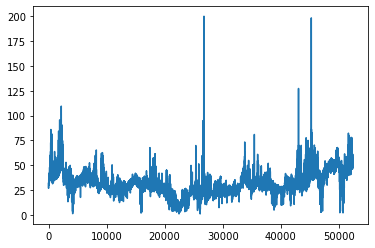

In [ ]:
from nixtlats.data.datasets.epf import EPF, EPFInfo
import matplotlib.pyplot as plt

dataset = ['NP']

Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=dataset)

X_df = X_df[['unique_id', 'ds', 'week_day']]
Y_min = Y_df.y.min()
#Y_df.y = Y_df.y - Y_min + 20

plt.plot(Y_df.y.values)
plt.show()

In [ ]:
# TODO: think about use of big windows during train for extremely long series
# backpropagation trough time is slow
# result = evaluate_model(loss_function=mae, mc=mc, 
#                         S_df=S_df, Y_df=Y_df, X_df=X_df, f_cols=[],
#                         ds_in_test=0, ds_in_val=728*24,
#                         n_uids=None, n_val_windows=None, freq=None,
#                         is_val_random=False, loss_kwargs={})
# result

In [ ]:
# plt.plot(result['y_hat'].flatten())
# plt.plot(Y_df['y'][-728*24:].values)

In [ ]:
trials = hyperopt_tunning(space=deepmidas_space, hyperopt_max_evals=2, loss_function=mae,
                          S_df=S_df, Y_df=Y_df, X_df=X_df, f_cols=[],
                          ds_in_val=728*24, n_uids=None, n_val_windows=None, freq=None,
                          is_val_random=False, loss_kwargs={})

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.074404 seconds
INFO:hyperopt.tpe:TPE using 0 trials



activation                                SELU
batch_normalization                      False
batch_size                                 256
complete_inputs                          False
complete_sample                          False
device                                     cpu
dropout_prob_exogenous                0.206928
dropout_prob_theta                    0.095228
early_stop_patience                         16
eval_freq                                   50
frequency                                    H
idx_to_sample_freq                          24
initialization                       he_normal
l1_theta                                     0
learning_rate                          0.00074
len_sample_chunks                         None
loss_hypar                                 0.5
loss_train                                 MAE
loss_valid                                 MAE
lr_decay                              0.488883
lr_decay_step_size                         100
max_epochs  

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2016-12-27 2018-12-24 23:00:00
          1           2013-01-01 2016-12-26 23:00:00
INFO:root:
Total data 			52416 time stamps 
Available percentage=100.0, 	52416 time stamps 
Insample  percentage=66.67, 	34944 time stamps 
Outsample percentage=33.33, 	17472 time stamps 

/Users/cchallu/NIXTLA/nixtlats/nixtlats/data/tsdataset.py:208: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2013-01-01 2016-12-26 23:00:00
  

Validation sanity check: 0it [00:00, ?it/s]
  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

/Users/cchallu/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."

/Users/cchallu/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."

/Users/cchallu/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightni

Training: -1it [00:00, ?it/s]
  0%|          | 0/2 [00:01<?, ?trial/s, best loss=?]

/Users/cchallu/anaconda3/envs/nixtla/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459064158/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)



Validating: 0it [00:00, ?it/s]
  0%|          | 0/2 [00:01<?, ?trial/s, best loss=?]

Metric val_loss improved. New best score: 6.787


Epoch 1:  50%|#####     | 1/2 [00:00<00:00, 16.80it/s, loss=4.69, v_num=25, train_loss_step=5.940, val_loss=6.790, train_loss_epoch=3.440]
Validating: 0it [00:00, ?it/s]
  0%|          | 0/2 [00:01<?, ?trial/s, best loss=?]

Metric val_loss improved by 2.640 >= min_delta = 0.0001. New best score: 4.147


Epoch 2:  50%|#####     | 1/2 [00:00<00:00, 27.44it/s, loss=4.29, v_num=25, train_loss_step=3.500, val_loss=4.150, train_loss_epoch=5.940] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|#####     | 1/2 [00:00<00:00, 26.65it/s, loss=4.21, v_num=25, train_loss_step=3.970, val_loss=4.840, train_loss_epoch=3.500] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|#####     | 1/2 [00:00<00:00, 22.06it/s, loss=4.11, v_num=25, train_loss_step=3.720, val_loss=4.500, train_loss_epoch=3.970] 
Validating: 0it [00:00, ?it/s]
  0%|          | 0/2 [00:01<?, ?trial/s, best loss=?]

Metric val_loss improved by 1.032 >= min_delta = 0.0001. New best score: 3.115


Epoch 5:  50%|#####     | 1/2 [00:00<00:00, 18.18it/s, loss=3.87, v_num=25, train_loss_step=2.670, val_loss=3.120, train_loss_epoch=3.720]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|#####     | 1/2 [00:00<00:00, 23.30it/s, loss=3.72, v_num=25, train_loss_step=2.820, val_loss=3.230, train_loss_epoch=2.670] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|#####     | 1/2 [00:00<00:00, 25.79it/s, loss=3.65, v_num=25, train_loss_step=3.110, val_loss=3.570, train_loss_epoch=2.820] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|#####     | 1/2 [00:00<00:00, 26.70it/s, loss=3.55, v_num=25, train_loss_step=2.790, val_loss=3.200, train_loss_epoch=3.110] 
Validating: 0it [00:00, ?it/s]
  0%|          | 0/2 [00:02<?, ?trial/s, best loss=?]

Metric val_loss improved by 0.281 >= min_delta = 0.0001. New best score: 2.834


Epoch 9: 100%|##########| 2/2 [00:00<00:00, 29.17it/s, loss=3.44, v_num=25, train_loss_step=2.460, val_loss=2.830, train_loss_epoch=2.790]
Validating: 0it [00:00, ?it/s]
  0%|          | 0/2 [00:02<?, ?trial/s, best loss=?]

/Users/cchallu/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."



Predicting: 1it [00:00, ?it/s]
Predicting: 100%|##########| 1/1 [00:00<?, ?it/s]
y_true.shape (#n_series, #n_fcds, #lt): (728,)
y_hat.shape (#n_series, #n_fcds, #lt): (728,)
 50%|█████     | 1/2 [00:02<00:02,  2.58s/trial, best loss: 1.9853875637054443]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013553 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.985388



activation                                SELU
batch_normalization                      False
batch_size                                 256
complete_inputs                          False
complete_sample                          False
device                                     cpu
dropout_prob_exogenous                0.459546
dropout_prob_theta                    0.337756
early_stop_patience                         16
eval_freq                                   50
frequency                                    H
idx_to_sample_freq                          24
initialization                   glorot_normal
l1_theta                                     0
learning_rate                         0.000546
len_sample_chunks                         None
loss_hypar                                 0.5
loss_train                                 MAE
loss_valid                                 MAE
lr_decay                              0.412224
lr_decay_step_size                         100
max_epochs  

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2016-12-27 2018-12-24 23:00:00
          1           2013-01-01 2016-12-26 23:00:00
INFO:root:
Total data 			52416 time stamps 
Available percentage=100.0, 	52416 time stamps 
Insample  percentage=66.67, 	34944 time stamps 
Outsample percentage=33.33, 	17472 time stamps 

/Users/cchallu/NIXTLA/nixtlats/nixtlats/data/tsdataset.py:208: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2013-01-01 2016-12-26 23:00:00
  

Validation sanity check: 0it [00:00, ?it/s]
 50%|█████     | 1/2 [00:03<00:02,  2.58s/trial, best loss: 1.9853875637054443]

/Users/cchallu/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."

/Users/cchallu/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."

/Users/cchallu/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightni

Training: -1it [00:00, ?it/s]
Epoch 0:  50%|#####     | 1/2 [00:00<00:00, 25.13it/s, loss=4.14, v_num=26, train_loss_step=4.140]
Validating: 0it [00:00, ?it/s]
 50%|█████     | 1/2 [00:03<00:02,  2.58s/trial, best loss: 1.9853875637054443]

Metric val_loss improved. New best score: 5.752


Epoch 1:  50%|#####     | 1/2 [00:00<00:00, 22.27it/s, loss=4.58, v_num=26, train_loss_step=5.020, val_loss=5.750, train_loss_epoch=4.140]
Validating: 0it [00:00, ?it/s]
 50%|█████     | 1/2 [00:04<00:02,  2.58s/trial, best loss: 1.9853875637054443]

Metric val_loss improved by 2.664 >= min_delta = 0.0001. New best score: 3.088


Epoch 2:  50%|#####     | 1/2 [00:00<00:00, 21.81it/s, loss=4.19, v_num=26, train_loss_step=3.410, val_loss=3.090, train_loss_epoch=5.020] 
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|##########| 2/2 [00:00<00:00, 29.57it/s, loss=4.14, v_num=26, train_loss_step=4.000, val_loss=4.460, train_loss_epoch=3.410]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|##########| 2/2 [00:00<00:00, 26.40it/s, loss=4.07, v_num=26, train_loss_step=3.780, val_loss=4.120, train_loss_epoch=4.000]
Validating: 0it [00:00, ?it/s]
 50%|█████     | 1/2 [00:04<00:02,  2.58s/trial, best loss: 1.9853875637054443]

Metric val_loss improved by 0.166 >= min_delta = 0.0001. New best score: 2.922


Epoch 5: 100%|##########| 2/2 [00:00<00:00, 28.26it/s, loss=3.89, v_num=26, train_loss_step=3.000, val_loss=2.920, train_loss_epoch=3.780]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|##########| 2/2 [00:00<00:00, 20.55it/s, loss=3.78, v_num=26, train_loss_step=3.090, val_loss=3.030, train_loss_epoch=3.000]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|#####     | 1/2 [00:00<00:00, 25.94it/s, loss=3.71, v_num=26, train_loss_step=3.230, val_loss=3.450, train_loss_epoch=3.090] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|#####     | 1/2 [00:00<00:00, 26.30it/s, loss=3.64, v_num=26, train_loss_step=3.080, val_loss=3.200, train_loss_epoch=3.230] 
Validating: 0it [00:00, ?it/s]
 50%|█████     | 1/2 [00:05<00:02,  2.58s/trial, best loss: 1.9853875637054443]

Metric val_loss improved by 0.174 >= min_delta = 0.0001. New best score: 2.749


Epoch 9:  50%|#####     | 1/2 [00:00<00:00, 22.69it/s, loss=3.55, v_num=26, train_loss_step=2.780, val_loss=2.750, train_loss_epoch=3.080] 
Validating: 0it [00:00, ?it/s]
 50%|█████     | 1/2 [00:05<00:02,  2.58s/trial, best loss: 1.9853875637054443]

Metric val_loss improved by 0.022 >= min_delta = 0.0001. New best score: 2.727


 50%|█████     | 1/2 [00:05<00:02,  2.58s/trial, best loss: 1.9853875637054443]

/Users/cchallu/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."



Predicting: 1it [00:00, ?it/s]
Predicting: 100%|##########| 1/1 [00:00<?, ?it/s]
y_true.shape (#n_series, #n_fcds, #lt): (728,)
y_hat.shape (#n_series, #n_fcds, #lt): (728,)
100%|██████████| 2/2 [00:05<00:00,  2.76s/trial, best loss: 1.9818161725997925]


In [ ]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 1.9853875637054443,
   'mc': {'activation': 'SELU',
    'batch_normalization': False,
    'batch_size': 256,
    'complete_inputs': False,
    'complete_sample': False,
    'device': 'cpu',
    'dropout_prob_exogenous': 0.2069281539939935,
    'dropout_prob_theta': 0.09522759273514453,
    'early_stop_patience': 16,
    'eval_freq': 50,
    'frequency': 'H',
    'idx_to_sample_freq': 24,
    'initialization': 'he_normal',
    'l1_theta': 0,
    'learning_rate': 0.0007396856533221593,
    'len_sample_chunks': None,
    'loss_hypar': 0.5,
    'loss_train': 'MAE',
    'loss_valid': 'MAE',
    'lr_decay': 0.488883166981553,
    'lr_decay_step_size': 100,
    'max_epochs': 10,
    'max_steps': None,
    'mode': 'simple',
    'model': 'deepmidas',
    'n_blocks': (1, 1),
    'n_freq_downsample': (24, 1),
    'n_hidden': 256,
    'n_layers': (2, 2),
    'n_pool_kernel_size': (4, 1),
    'n_s_hidden': 0,
    'n_series_per_batch': 1